# Exploratory Data Analysis (EDA) on the dataset of fire images
After the Data Acquisition stage, conducting EDA is important to:
- Understand the acquired data
- Ensure the training set contains a variety of images and not biased
- Handle data imbalance (if any)

## Number of images
The dataset is split into 2 portions:
1. **Training set:** 2712 images  
Data augmentation methods are not applied.      
2. **Validation set**: 728 images
3. **Testing set for the model:** 443 images
4. **Testing set for the alarming system:** [...] videos            
The model is applied to recognize fire and smoke in each frame of videos


In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

In [ ]:
# !pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="BZTREFbhM5T8N26Kzvy3")
project = rf.workspace("fire-rqbio").project("fire-and-smoke-yikzn")
version = project.version(3)
dataset = version.download("yolov8")

In [4]:
def show_images(folder, title, n=15, rows=3):
    '''
    Visualize 15 images selected randomly in the training set
    
    Args:
    folder      directory of the training set
    title       title to show in the figure, i.e. "Sample images"
    
    Output:
    Plot 15 randomly selected images in 3 rows, 5 columns
    '''
    files = os.listdir(folder)
    random_files = random.sample(files,n)
    
    cols = int(n / rows)
    plt.figure(figsize=(5 * cols, 4 * rows))

    
    for i, file in enumerate(random_files):
        img = cv2.imread(os.path.join(folder, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()



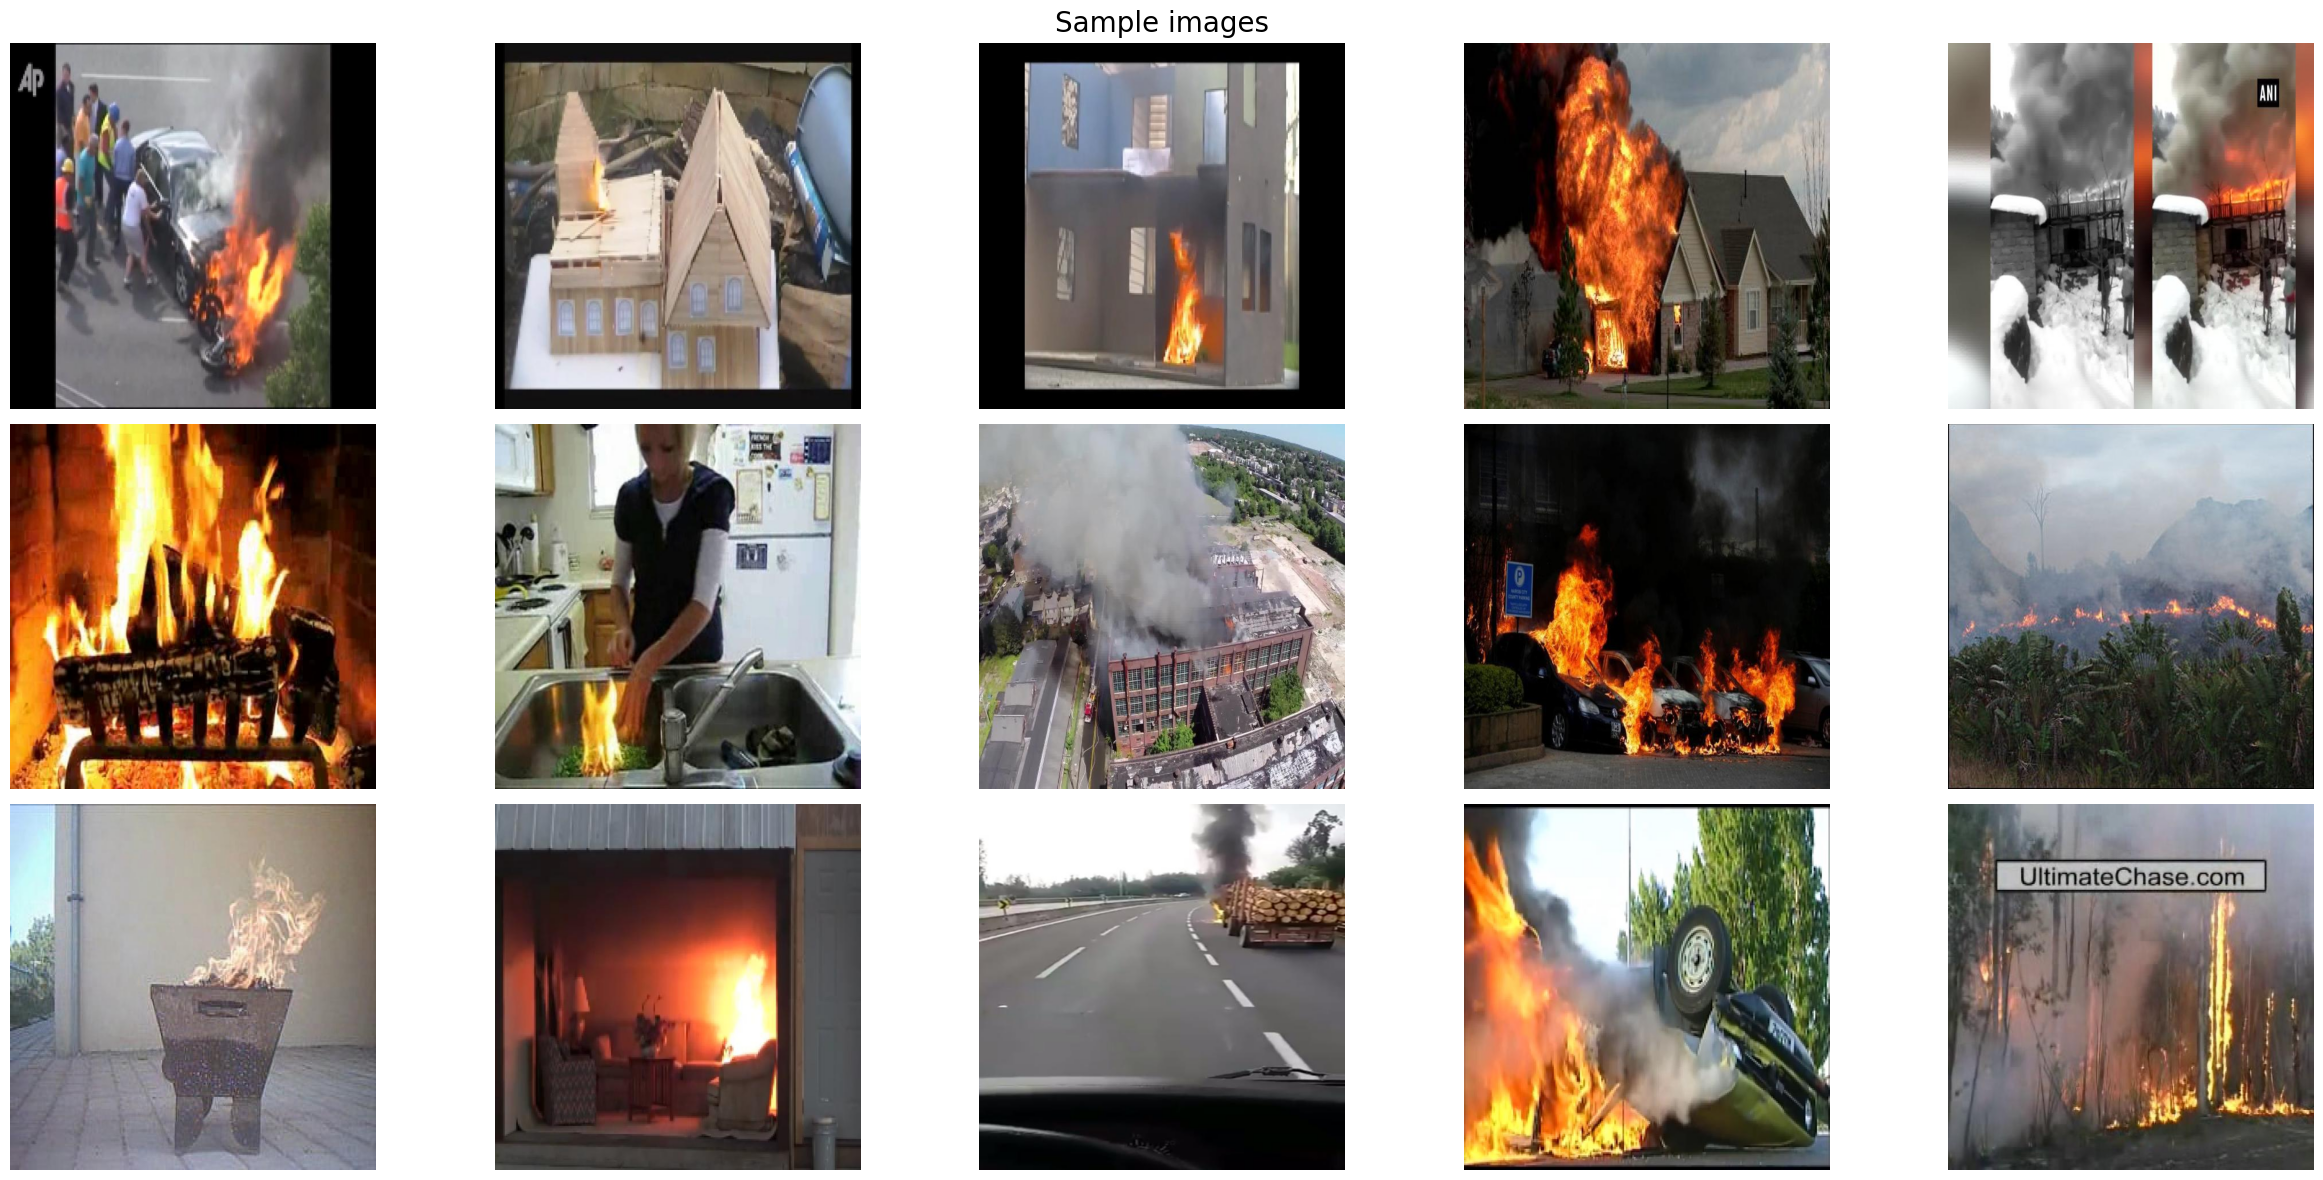

In [ ]:
show_images("D:/School/machine_learning/fire_detection/FireDetectionSystem/src/roboflow/train/images", "Sample images")

**Observe that:**            
- The training set contains various types of fire, which increases the accuracy of fire detection:
    - Big fire (building fire, warehouse fire, forest fire)
    - Small/Starting fire (lighter, kitchen fire incident)
- Images are auto-oriented            
$\rightarrow$ To ensure model robustness, it is necessary to apply Data Augmentation methods on the training set:    
    - Rotate
    - Shear
    - Flip
    - Random crop

## Bounding-box Analysis
Bounding boxes are represented by label ```.txt``` files in the labels directory.          
Labels use YOLO format: ```<class> <x coordinate> <y coordinate> <width> <height>```  
                 
In the case of fire detection, fire is labelled as 0 and smoke is labelled as 1.

### Count number of bounding boxes

In [ ]:
def analyze_bbox(img_dir, label_dir, image_ext=".jpg"):
    '''
    Count the total number of images, detect unlabelled images (without boxes), 
    minimum and maximum number of boxes in images
    
    Args:
    label_dir           Directory of label files (.txt, YOLOv8 format)
    image_ext=".jpg"    Default image extension (.jpg)
    
    Output:
    Print total number of images, unlabelled images, min and max boxes in images
    Plot a histogram of 
    '''
    box_counts = []
    total_images = 0

    for label_file in os.listdir(label_dir):
        if not label_file.endswith(".txt"): # if the file is not in the format, ignore
            continue

        label_path = os.path.join(label_dir, label_file) # get the full path of the label file

        with open(label_path, "r") as f:
            lines = f.readlines()
            box_counts.append(len(lines))  # number of boxes in one image
    
    # count the total number of images
    for img_file in os.listdir(img_dir):
        if os.path.isfile(os.path.join(img_dir, img_file)):
            total_images += 1
    
    boxed_images = len(box_counts)
    no_box_images = total_images - boxed_images
    
    min_box_count = min(box_counts)
    max_box_count = max(box_counts)
    
    return box_counts, total_images, boxed_images, no_box_images, max_box_count, min_box_count

Bounding-box Analysis
Labelled images: 2712
Unlabelled images: 0
Max boxes in an image: 11
Min boxes in an image: 0


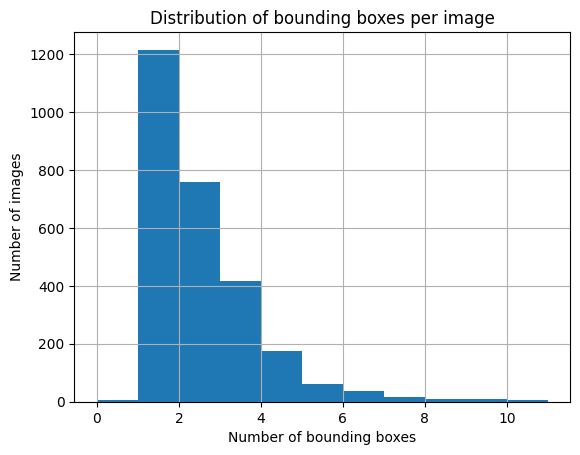

In [ ]:
label_folder = "D:/School/machine_learning/fire_detection/FireDetectionSystem/src/roboflow/train/labels"
image_folder = "D:/School/machine_learning/fire_detection/FireDetectionSystem/src/roboflow/train/images"
box_counts, _, boxed_images, no_box_images, max_box_count, min_box_count = analyze_bbox(image_folder, label_folder)

print("Bounding-box Analysis")
print(f"Labelled images: {boxed_images}")
print(f"Unlabelled images: {no_box_images}")
print(f"Max boxes in an image: {max_box_count}")
print(f"Min boxes in an image: {min_box_count}")
    
# histogram of bounding box counts
plt.hist(box_counts, bins=range(0, max(box_counts)+1), align='mid')
plt.title("Distribution of bounding boxes per image")
plt.xlabel("Number of bounding boxes")
plt.ylabel("Number of images")
plt.grid(True)
plt.show()

**Observe that:**             
The training set consists of 2712 fire and smoke images and there is no images without bounding boxes.

### Analyse size of bounding boxes

In [ ]:
def yolo_to_bbox(yolo_bbox, img_width, img_height):
    """Convert YOLO bbox format to (xmin, ymin, xmax, ymax) in pixels"""
    cls, x_center, y_center, width, height = map(float, yolo_bbox)
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height
    xmin = int(x_center - width / 2)
    ymin = int(y_center - height / 2)
    xmax = int(x_center + width / 2)
    ymax = int(y_center + height / 2)
    return int(cls), (xmin, ymin, xmax, ymax)

In [6]:
def extract_crops(images_dir, labels_dir):
    '''
    Extract/Crop the fire and smoke regions in images
    to analyze area of boxes
    Args:
        image_dir       directory of images
        labels_dir      directory of labels
    Return:
        fire_crops      cropped images that contain fire
        boxes_size      size of cropped images that contain fire (in pixels)
    '''
    
    fire_crops = []
    bbox_sizes = []

    for filename in os.listdir(images_dir):
        if not filename.endswith((".jpg", ".png", ".jpeg")):
            continue

        image_path = os.path.join(images_dir, filename)
        label_path = os.path.join(labels_dir, filename.replace(".jpg", ".txt").replace(".png", ".txt"))

        if not os.path.exists(label_path):
            continue  # skip if no label

        image = Image.open(image_path).convert("RGB")
        img_width, img_height = image.size

        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            cls, bbox = yolo_to_bbox(line.strip().split(), img_width, img_height)
            if cls == 0:  # only extract fire
                xmin, ymin, xmax, ymax = bbox
                fire_crop = image.crop((xmin, ymin, xmax, ymax))
                fire_crops.append(fire_crop)
                bbox_sizes.append((xmax - xmin, ymax - ymin))  # width, height

    return fire_crops, bbox_sizes

In [19]:
def analyze_bbox_sizes(sizes):
    areas = [w * h for w, h in sizes]

    plt.hist(areas, bins=30, align="mid")
    plt.xlim((0, 250000))
    plt.xlabel("Number of pixels in cropped region")
    plt.ylabel("Number of bounding boxes")
    plt.title("Distribution of Bounding box Areas")
    plt.grid("on")
    plt.show()


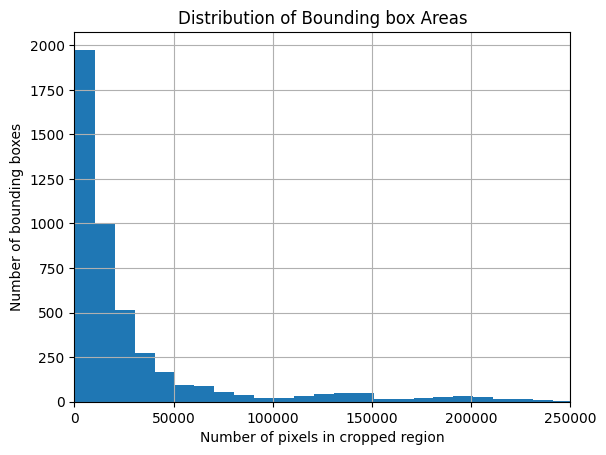

In [20]:
all_crops = []
all_sizes = []

folders = [
    ("D:/School/machine_learning/fire_detection/FireDetectionSystem/src/roboflow/train/images", "D:/School/machine_learning/fire_detection/FireDetectionSystem/src/roboflow/train/labels"),
    ("D:/School/machine_learning/fire_detection/FireDetectionSystem/src/roboflow/test/images", "D:/School/machine_learning/fire_detection/FireDetectionSystem/src/roboflow/test/labels"),
    ("D:/School/machine_learning/fire_detection/FireDetectionSystem/src/roboflow/valid/images", "D:/School/machine_learning/fire_detection/FireDetectionSystem/src/roboflow/valid/labels")
]

for img_dir, lbl_dir in folders:
    crops, sizes = extract_crops(img_dir, lbl_dir)
    all_crops.extend(crops)
    all_sizes.extend(sizes)

# plot_rgb_histograms(all_crops)
analyze_bbox_sizes(all_sizes)


**Observe that:** Sizes of bounding boxes varies from 1000 to 250000 pixels per image, indicating that the training set contains various types of fire (small/starting fire, big fire)

## Annotation Heatmap
Annotation Heatmaps indicate the typical region of fire and smoke appearing in training set.

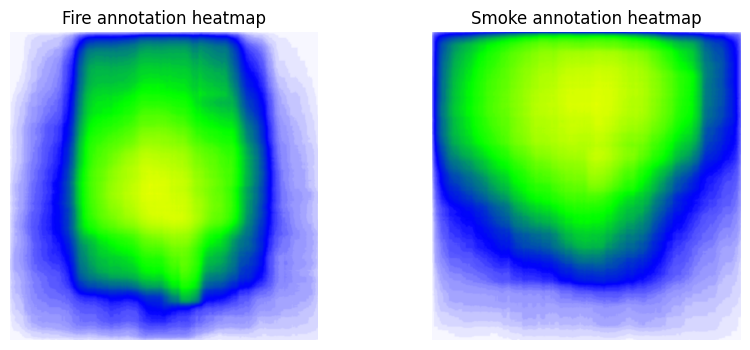

In [ ]:
fire_hm = plt.imread("fire_heatmap.png")
smoke_hm = plt.imread("smoke_heatmap.png")

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(fire_hm)
plt.title("Fire annotation heatmap")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(smoke_hm)
plt.title("Smoke annotation heatmap")
plt.axis("off")

plt.show()

**Observe that**: 
- Fire regions tend to concentrate in the center of the image (grounded or near the source) and grows vertically
- Smoke regions occupy the upper half and more horizontally spread than fire            
$\rightarrow$ Annotations follow realistic distribution of fire and smoke.